# Noah Corona

---

# CS 165B HW 4

# Fashion Classification


## Setup

In [1]:
"""install tensorflow, keras, gdown"""
!pip install tensorflow keras gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
"""Download the data"""
!gdown https://drive.google.com/uc?id=1kpvqpmN5Kk-U6vg-ZoXTzp22ooD8_Vty
!unzip 'Data.zip' -d './'

Streaming output truncated to the last 5000 lines.
  inflating: ./hw4_train/5/5_3721.png  
  inflating: ./__MACOSX/hw4_train/5/._5_3721.png  
  inflating: ./hw4_train/5/5_472.png  
  inflating: ./__MACOSX/hw4_train/5/._5_472.png  
  inflating: ./hw4_train/5/5_5350.png  
  inflating: ./__MACOSX/hw4_train/5/._5_5350.png  
  inflating: ./hw4_train/5/5_1136.png  
  inflating: ./__MACOSX/hw4_train/5/._5_1136.png  
  inflating: ./hw4_train/5/5_1888.png  
  inflating: ./__MACOSX/hw4_train/5/._5_1888.png  
  inflating: ./hw4_train/5/5_1650.png  
  inflating: ./__MACOSX/hw4_train/5/._5_1650.png  
  inflating: ./hw4_train/5/5_314.png  
  inflating: ./__MACOSX/hw4_train/5/._5_314.png  
  inflating: ./hw4_train/5/5_5436.png  
  inflating: ./__MACOSX/hw4_train/5/._5_5436.png  
  inflating: ./hw4_train/5/5_2359.png  
  inflating: ./__MACOSX/hw4_train/5/._5_2359.png  
  inflating: ./hw4_train/5/5_3047.png  
  inflating: ./__MACOSX/hw4_train/5/._5_3047.png  
  inflating: ./hw4_train/5/5_4728.png  
  i

In [3]:
"""Define paths of input folders, output file, and saved model"""
train_dir = './hw4_train'
test_dir = './hw4_test'
output_file = './prediction.txt'
output_archive = './prediction.zip'
model_path = './models/saved_model.hdf5'

"""whether to train model or load from pretrained model"""
load_pretrained = False

In [4]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory as import_dataset
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.data import Dataset, AUTOTUNE
from numpy import argmax, concatenate
import matplotlib.pyplot as plt

## Image Classifier Implementation

In [5]:
class ImageClassifier(object):
    val_data: Dataset
    test_data: Dataset
    epochs: int
    batch_size: int
    model: Model
    model_path: str

    def __init__(self, model, params, model_path):
        """
        args
            model: model definition to use
        """
        self.model = model
        self.model_path = model_path
        self.batch_size = params['batch_size']
        self.epochs = params['training_epochs']
        self.checkpoint_save = ModelCheckpoint(
            self.model_path,
            save_best_only=True,
            monitor='val_loss',
            mode='min')
        self.reduce_lr_loss = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=15,
            verbose=1,
            mode='min')

    def train(self, train_data_dir):
        """
        Main training routine
            - Load the data from the specified directory
            - Split into training and validation sets
            - Train the model
            - Plot the training metrics

        args
            train_data_dir: path of training data to be loaded, or None to load last model
            training_params: dictionary of training parameters
        """
        train_data = import_dataset(
            train_data_dir,
            shuffle=True,
            image_size=(28, 28),
            color_mode='grayscale',
            batch_size=self.batch_size,
            labels='inferred',
            label_mode='int',
            subset='training',
            validation_split=0.2,
            seed=42).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
        val_data = import_dataset(
            train_data_dir,
            shuffle=False,
            image_size=(28, 28),
            color_mode='grayscale',
            batch_size=self.batch_size,
            labels='inferred',
            label_mode='int',
            subset='validation',
            validation_split=0.2,
            seed=42).cache().prefetch(buffer_size=AUTOTUNE)
        self.model.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
        fit_data = self.model.fit(
            train_data,
            validation_data=val_data,
            epochs=self.epochs,
            callbacks=[self.checkpoint_save,
                       self.reduce_lr_loss])
        self.plot_training_metrics(
            fit_data=fit_data,
            metrics={'accuracy', 'loss'})

    def save(self):
        """
        Saves the current model to the specified path

        args
            model_path: path of model to save or load (.pb extension)
        """
        self.model.save(self.model_path)

    def load(self):
        """
        Loads the current model from the specified path

        args
            model_path: path of model to save or load (.pb extension)
        """
        self.model = tf.saved_model.load(self.model_path)

    @staticmethod
    def plot_training_metrics(fit_data, metrics):
        """
        Generate a joint training/validation plot for each of
        the given metrics over number of epochs

        args
            x_axis: x-axis of the plots
            fit_data: model fit data generated during training
            metrics: the metrics to be compared
        """

        plt.figure(figsize=(10, 10))
        for idx, metric in enumerate(metrics):
            plt.subplot(1, len(metrics), idx + 1)
            plt.title(metric.capitalize())
            plt.plot(fit_data.history[metric], label='Training ' + metric)
            plt.plot(fit_data.history['val_' + metric], label='Validation ' + metric)
            plt.legend()
        plt.show()

    def predict(self, test_data_dir):
        """
        Predict labels on the given test dataset
        Write over file 'predictions.txt' with all predictions as integers, one per line

        args
            directory of test dataset to be loaded
        """

        test_data = import_dataset(test_data_dir,
                                   shuffle=False,
                                   batch_size=None,
                                   image_size=(28, 28),
                                   color_mode='grayscale',
                                   labels=None,)
        y = concatenate([tf.expand_dims(image, 0) for image in test_data], axis=0)
        print('test data shape', y.shape)
        predictions = self.model.predict(y)
        as_str = []
        for prediction in predictions:
            as_str.append(str(argmax(prediction)))
        return as_str


## Define the TensorFlow Model and Parameters

In [10]:
# model parameters
params = {
    'batch_size': 32,       # batch size
    'training_epochs': 30   # number of training epochs
}

"""
    # 2D convolutional layer with max pooling and dropout at 10%
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.1),
"""

# model definition
model = Sequential([
    # input layer with pixel normalization
    layers.Rescaling(1. / 255, input_shape=(28, 28, 1)),
    # preprocessing helps reduce over-fitting
    layers.RandomRotation(0.05),
    layers.Flatten(),
    # one fully connected layer before output with dropout at 20%
    layers.Dense(100, activation='relu'),

    # output layer
    layers.Dense(10)
])

## Train the Model

Found 50400 files belonging to 10 classes.
Using 40320 files for training.
Found 50400 files belonging to 10 classes.
Using 10080 files for validation.
Epoch 1/30
1260/1260 [==============================] - 9s 4ms/step - loss: 0.9739 - accuracy: 0.6531 - val_loss: 0.5518 - val_accuracy: 0.8211 - lr: 0.0010
Epoch 2/30
1260/1260 [==============================] - 3s 3ms/step - loss: 0.7822 - accuracy: 0.7192 - val_loss: 0.4726 - val_accuracy: 0.8499 - lr: 0.0010
Epoch 3/30
1260/1260 [==============================] - 3s 3ms/step - loss: 0.7128 - accuracy: 0.7434 - val_loss: 0.3421 - val_accuracy: 0.9017 - lr: 0.0010
Epoch 4/30
1260/1260 [==============================] - 3s 3ms/step - loss: 0.6724 - accuracy: 0.7597 - val_loss: 0.3272 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 5/30
1260/1260 [==============================] - 4s 3ms/step - loss: 0.6406 - accuracy: 0.7702 - val_loss: 0.2942 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 6/30
1260/1260 [==============================] - 3s 3ms/

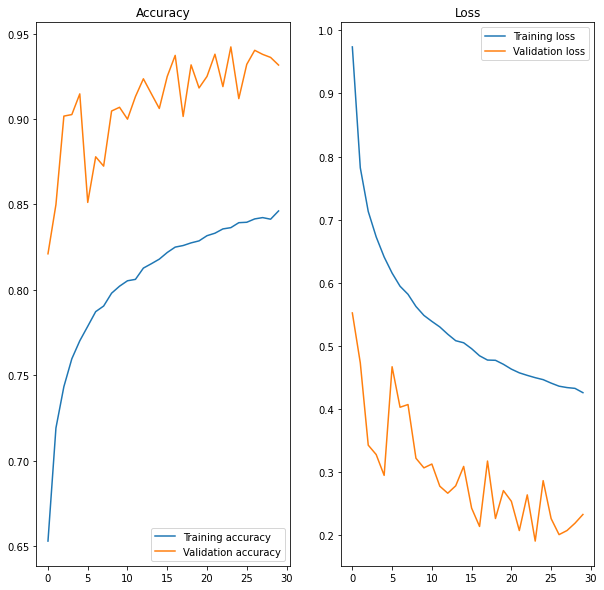

In [11]:
# load model into image classifier class
fashionClassifier = ImageClassifier(model, params, model_path)

# either load or save the data
if load_pretrained:
    fashionClassifier.load()
else:
    fashionClassifier.train(train_dir)
    fashionClassifier.save()

## Generate the Predictions File

In [12]:
# make predictions on the test data and write them to the output file
import numpy
predictions = fashionClassifier.predict(test_dir)
print('Generating ./prediction.txt with', len(predictions), 'predictions')
with open('./prediction.txt', 'w') as f:
    for idx, pred in enumerate(predictions):
        f.write(pred + '\n' if idx != (len(predictions) - 1) else pred)
# for CodaLab submission
!zip -r './prediction.zip' './prediction.txt'
print('Program finished')


Found 10000 files belonging to 1 classes.
test data shape (10000, 28, 28, 1)
Generating ./prediction.txt with 10000 predictions
  adding: prediction.txt (deflated 70%)
Program finished
